### Hasan Farooq (23-03-0016)
This notebook a refined version of the work. It will take 2-3 minutes to execute al the cells.

## Summary
This notebook shows the results of using Decision Trees on the dataset.

### Data Processing and Feature Selection
- **Null Values :** In the dataset, some features were mostly missing values. I've discarded the features on a set threshold (>40% missing data).
- **Correlation :** I have selected the numerical features by analyzing the correlation matrix. The features that were very correlated have been discarded to avoid redundancy. 
- **Non-Numerical :** While differentiating the numerical/non-numerical features, I have analyzed the uniqueness of each feature. For instance, if a feature has 3 numerical unique values, I have treated those as classification features.
- **Scaling :** Upon reading the content, I found that tree based methods are not affected by scaling. That's why I have not used feature scaling.
- **Missing Values :** Since some features had a high number of missing values, I have not filled them randomly or with a fixed value. Instead, I have experimented with KNN and Regression methods to fill values.
- **New Features :** The date feature proved to be of high value. That's why I have splitted the date into months, quarters, days for new features.
- **Memory Saving :** Our dataset contained more than 4 lac entries with 50+ features. After feature selection, I have quantized the dataset for faster operations.


### Model 
I have used the Decision Tree regressor for the problem. I have tuned the hyper-parameters by Grid Search to start with. Later, I have used techniques like pruning and regularization to avoid overfitting. Also, I limited
the parameters like depth and max-features (features used to make a decision for splits). This helps the model avoid relying too much on one feature and predict using more features.

### Evaluation
For the evaluation of the model, I have used the metric used in the official dataset documentation **RMSLE**. For better understanding of the model, I used visualizations of the tree. These included generic decision paths for making predictions and the importance of each feature in making the decision. The pruned model gives an RSMLE of 0.4 and the model focuses more on the features of the actual product for predicting the sale price.



In [117]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV

import random

import warnings
warnings.filterwarnings('ignore')

In [118]:
dir_path = "./data/"

In [119]:
df = pd.read_csv(dir_path + "TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

### Samples from Dataframe

In [120]:
df.sample(2)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
126128,1473164,11000.0,1076048,7511,132,2.0,1991,NaN,NaN,2001-11-09,...,18 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
106394,1434903,65000.0,556600,1597,132,1.0,2001,NaN,NaN,2004-12-02,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,VPAT,Finger Tip,NaN,NaN


# Data Processing 

In [121]:
features = (df.isnull().sum()/len(df)).sort_values(ascending=False).index
values = (df.isnull().sum()/len(df)).sort_values(ascending=False).values*100

### Plotting Null Values by Column

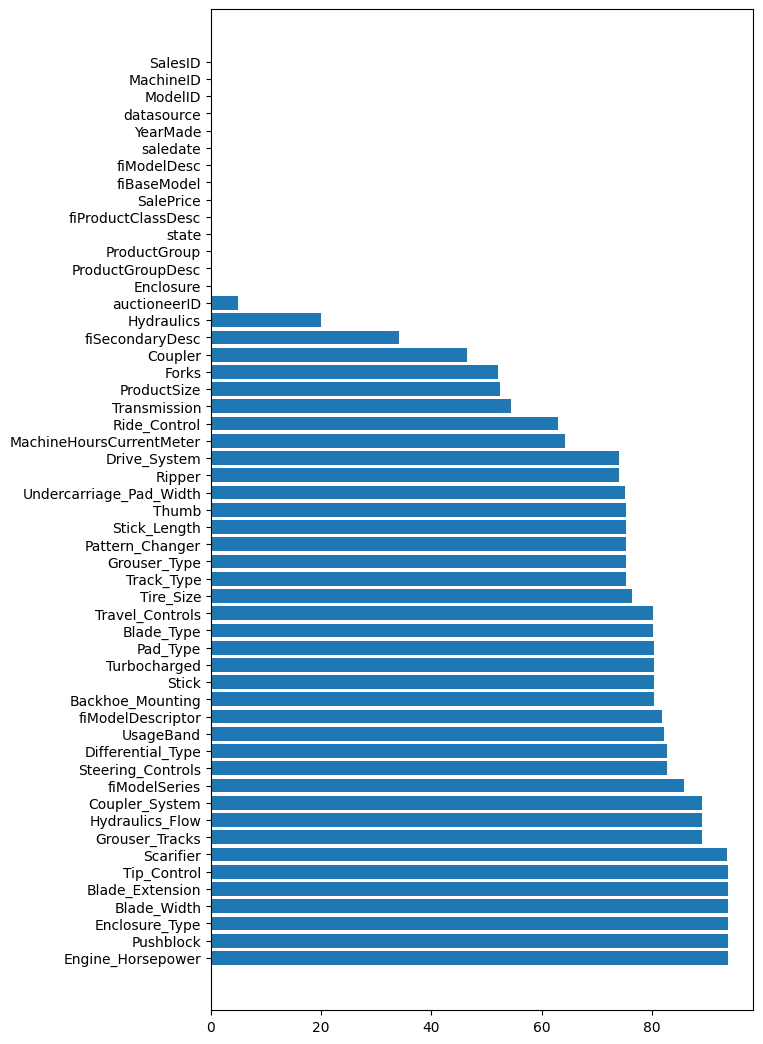

In [122]:
plt.figure(figsize=(7,13))
plt.barh(features,values)
plt.show()

In [123]:
selected_features = list(features[-16:])
df = df[selected_features]

In [124]:
df.sample(2)

,Hydraulics,auctioneerID,Enclosure,ProductGroupDesc,ProductGroup,state,fiProductClassDesc,SalePrice,fiBaseModel,fiModelDesc,saledate,YearMade,datasource,ModelID,MachineID,SalesID
133453,Standard,10.0,EROPS w AC,Track Excavators,TEX,Louisiana,"Hydraulic Excavator, Track - 40.0 to 50.0 Metr...",50000.0,235,235D,2001-12-11,1993,132,3416,58713,1489500
191534,NaN,1.0,OROPS,Backhoe Loaders,BL,Texas,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,16000.0,310,310D,2004-09-24,1996,132,4603,1549813,1628379


### Correlations b/w Numeric Features and Target Variable

These features repesent a better correlation matrix than all of the features combined

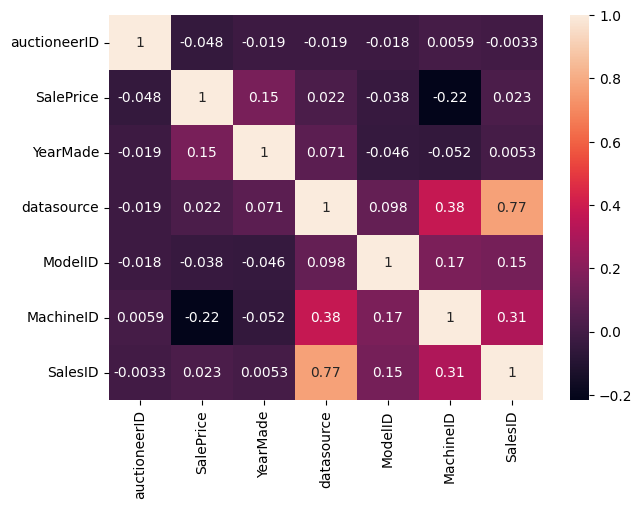

In [125]:
plt.figure(figsize=(7,5))
sns.heatmap(df.select_dtypes(np.number).corr(), annot=True)
plt.show()

### Distribution of Target Variable

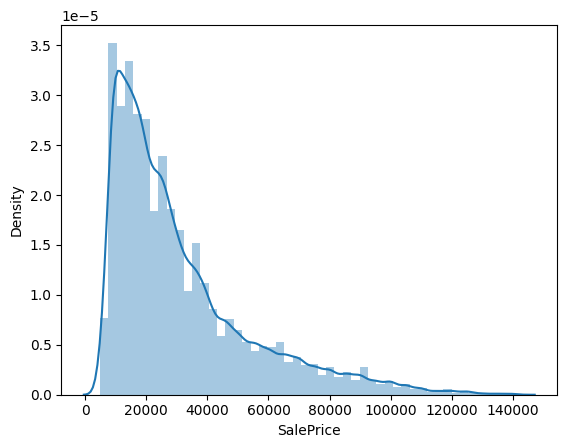

In [126]:
sns.distplot(df.SalePrice, label="SalePrice", bins=50,kde=True)
plt.show()

### Date relation with Target Variable

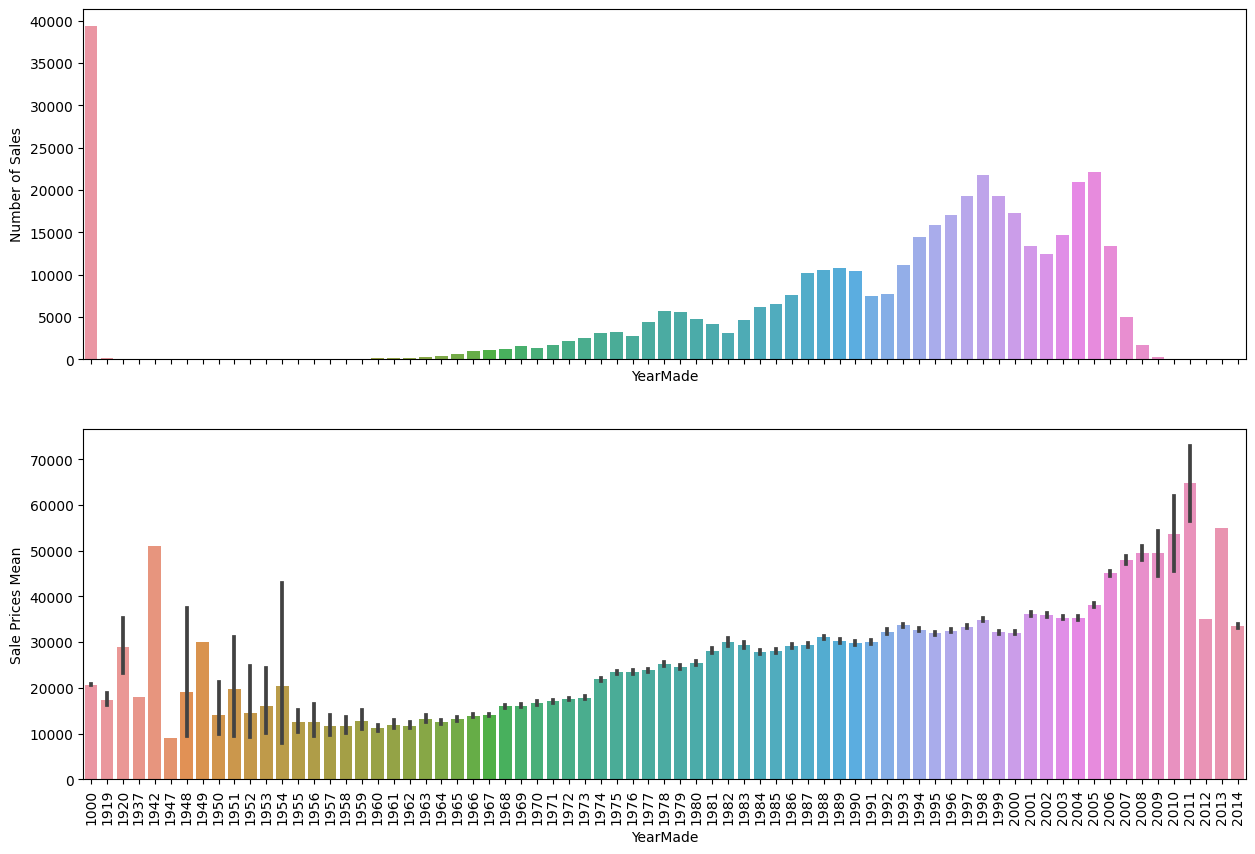

In [127]:
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 10))

sns.countplot(x="YearMade",
              data=df,
              ax=ax0)
ax0.set_ylabel("Number of Sales")

sns.barplot(x="YearMade",
            y="SalePrice",
            data=df,
            ax=ax1)
ax1.set_ylabel("Sale Prices Mean")

plt.xticks(rotation=90)
plt.show()

### Uniqueness of Features


In [128]:
n_uniques = []
names = []
for each in df:
        n_uniques.append(len(df[each].unique()))
        names.append(each)


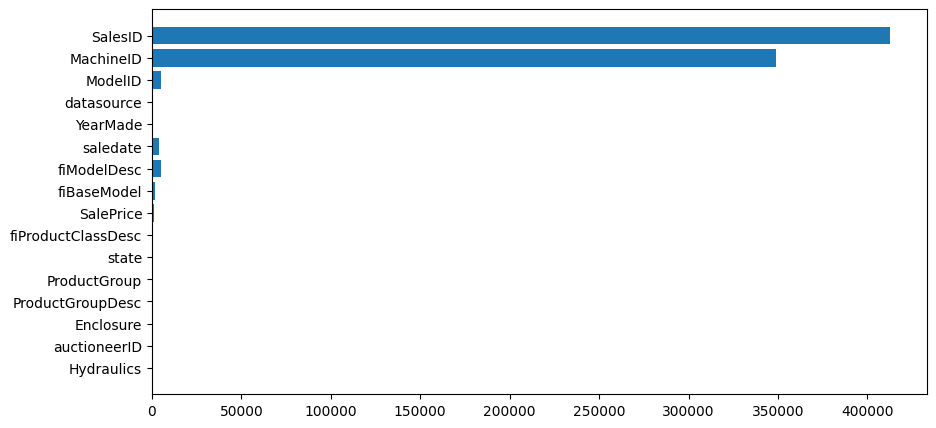

In [129]:
plt.figure(figsize=(10,5))
plt.barh(names, n_uniques)
plt.show()

### Expanding Date Column as Features

In [130]:
def add_date_parts(df):
    saledate = df.saledate

    df["sale_day"] = saledate.dt.day
    df["sale_month"] = saledate.dt.month
    df["sale_quarter"] = saledate.dt.quarter
    df["sale_year"] = saledate.dt.year
    df["sale_is_month_start"] = saledate.dt.is_month_start
    df["sale_is_month_end"] = saledate.dt.is_month_end
    df["sale_is_year_start"] = saledate.dt.is_year_start
    df["sale_is_year_end"] = saledate.dt.is_year_end

    df.drop("saledate", axis=1, inplace=True)
    
    return df

In [131]:
df = add_date_parts(df)

In [132]:
df.sample(2)

,Hydraulics,auctioneerID,Enclosure,ProductGroupDesc,ProductGroup,state,fiProductClassDesc,SalePrice,fiBaseModel,fiModelDesc,...,MachineID,SalesID,sale_day,sale_month,sale_quarter,sale_year,sale_is_month_start,sale_is_month_end,sale_is_year_start,sale_is_year_end
391975,Auxiliary,1.0,EROPS,Track Excavators,TEX,Florida,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",8500.0,TB125,TB125,...,1515468,4408147,27,10,4,2010,False,False,False,False
387213,Auxiliary,1.0,EROPS w AC,Track Excavators,TEX,Washington,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",72500.0,ZX330,ZX330LC,...,2302725,4336236,19,12,4,2011,False,False,False,False


### Downcast
> Idea taken from online notebook to reduce memory consumption. Saves more than 90% memory

In [133]:
def downcast(df):
    """
    Downcasts the columns of a Dataframe in order to save memory
    """
    df_copy = df.copy()
    
    for nm, col in df_copy.items():
        if pd.api.types.is_integer_dtype(col):
            col_min, col_max = col.min(), col.max()
            if (col_min > np.iinfo(np.int8).min
                    and col_max < np.iinfo(np.int8).max):
                df_copy[nm] = col.astype(np.int8)
            elif (col_min > np.iinfo(np.int16).min
                  and col_max < np.iinfo(np.int16).max):
                df_copy[nm] = col.astype(np.int16)
            elif (col_min > np.iinfo(np.int32).min
                  and col_max < np.iinfo(np.int32).max):
                df_copy[nm] = col.astype(np.int32)
            else:
                df_copy[nm] = cols.astype(np.int64)
        elif pd.api.types.is_float_dtype(col):
            col_min, col_max = col.min(), col.max()
            #-----------------------------------------------------------
            # In pandas stable, half floats (float16) is not implemented
            #-----------------------------------------------------------
            # if (col_min > np.finfo(np.float16).min
            #         and col_max < np.finfo(np.float16).max):
            #     df_copy[nm] = col.astype(np.float16)
            # elif (col_min > np.finfo(np.float32).min
            #-----------------------------------------------------------
            if (col_min > np.finfo(np.float32).min
                  and col_max < np.finfo(np.float32).max):
                df_copy[nm] = col.astype(np.float32)
            else:
                df_copy[nm] = cols.astype(np.float64)
        elif pd.api.types.is_object_dtype(col):
            df_copy[nm] = col.astype("category")
            
    return df_copy

In [134]:
df = downcast(df)

# Preprocessing


## Converting categories to numbers

In [135]:
df.select_dtypes(exclude=np.number).shape

(412698, 12)

In [136]:
for row, col in df.items():
    if pd.api.types.is_categorical_dtype(col):
        df[row] = col.cat.codes + 1

In [137]:
X_df = df.drop("SalePrice",axis=1).drop("SalesID",axis=1).values
y_df = df.SalePrice.values

## Filling missing numerical values with the Regression

In [138]:
imputer = IterativeImputer(random_state=42)

In [139]:
X_df = imputer.fit_transform(X_df)

In [140]:
np.isnan(X_df).sum()

0

## Modelling

In [141]:
X_df.shape, y_df.shape

((412698, 21), (412698,))

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((247618, 21), (247618,), (66032, 21), (66032,), (99048, 21), (99048,))

## Decision Tree

In [143]:
# Used for Slecting hyper-parameters using GridCV

# params = {'max_depth': [6,8,10,12],
#          'min_samples_split': [20,100,500],
#          'max_features': [5,10,15],
#          'ccp_alpha' : [0.05,0.1,0.2]}

In [146]:
model = DecisionTreeRegressor(random_state=42, min_samples_split=100, max_features=10, ccp_alpha=0.2,
                             max_depth=8,min_samples_leaf=5)

model.fit(X_train, y_train)
model.score(X_val, y_val)

0.579571399082379

In [147]:
y_pred = model.predict(X_test)

# print("MSE : ", round(mean_squared_error(y_pred=y_pred, y_true=y_test),2))
# print("MAE : ", round(mean_absolute_error(y_pred=y_pred, y_true=y_test),2))
print("RMSLE : ", round(mean_squared_log_error(y_pred=y_pred, y_true=y_test, squared=False),2))


RMSLE :  0.44


## Examining the Tree

In [148]:
tree_features = df.drop("SalePrice",axis=1).drop("SalesID",axis=1).columns
len(tree_features)

21

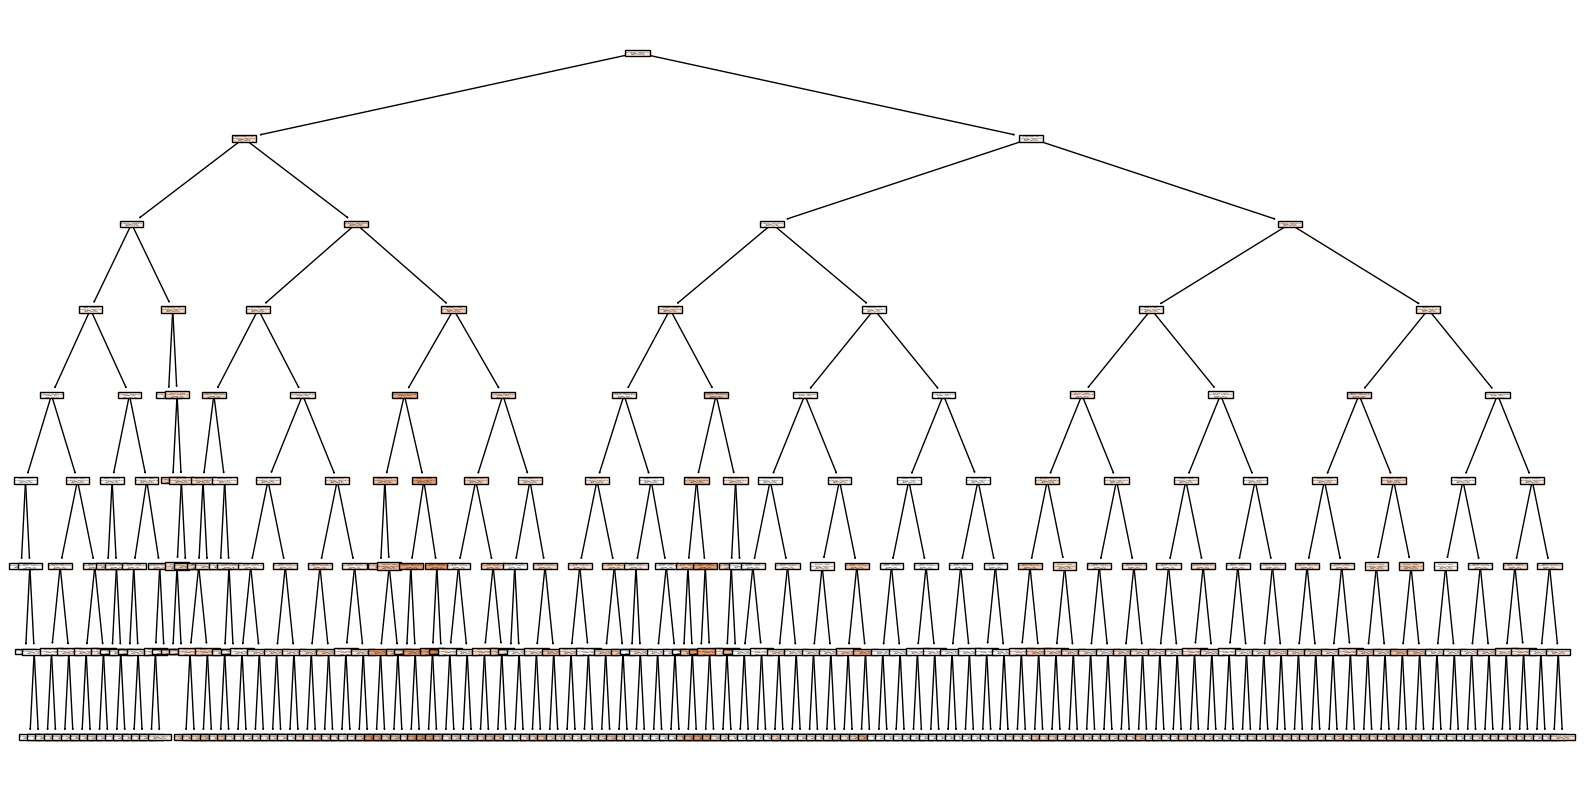

In [112]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=tree_features,filled=True)
plt.show()

In [149]:
feature_imp = model.feature_importances_
len(feature_imp)

21

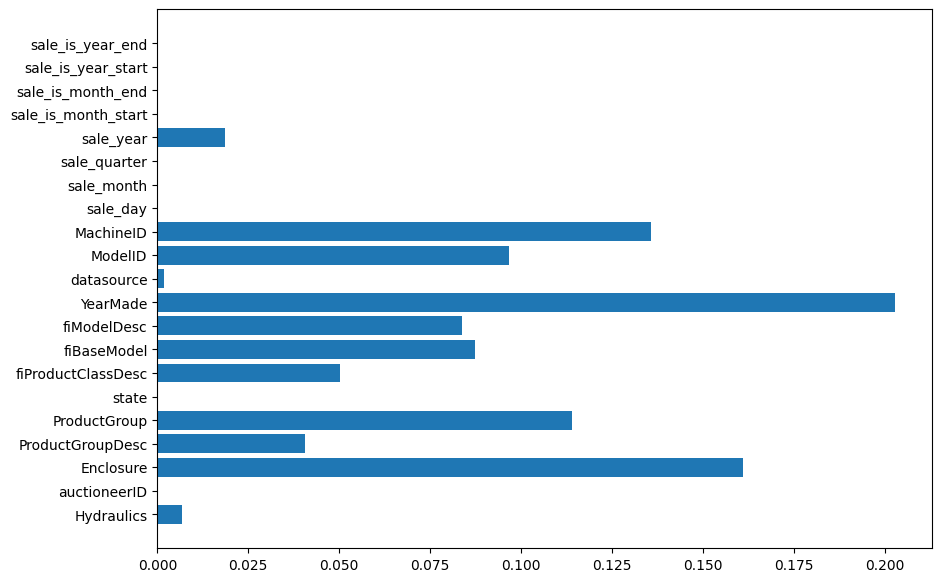

In [150]:
plt.figure(figsize=(10,7))
plt.barh(tree_features, feature_imp)
plt.show()

### Plotting random predictions

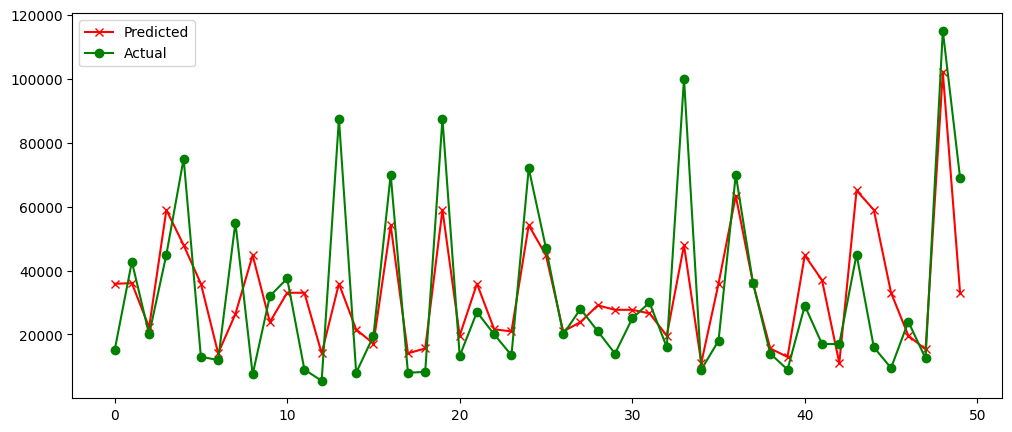

In [33]:
random_num = random.randint(0,y_test.shape[0])
n_samples = 50

plt.figure(figsize=(12,5))
plt.plot(y_pred[random_num:random_num+n_samples], color="r",label="Predicted",marker="x")
plt.plot(y_test[random_num:random_num+n_samples], color="g",label="Actual",marker="o")
plt.legend()
plt.show()